In [1]:
import numpy as np
from PIL import Image
import PIL
from matplotlib import pyplot as plt
import math

from glob import glob
import os
import random
from dicttoxml import dicttoxml

import ipywidgets as widgets
from IPython.display import display
from tqdm import tqdm

# http://blog.mmast.net/python-image-processing-libraries-performance-opencv-scipy-scikit-image

In [2]:
%matplotlib inline

In [3]:
def open_image(path):
    img = Image.open(path)
    #img = img.convert('RGB')
    return img

In [4]:
# list with class labels, replace with your labels
object_names = ["limit100", "limit20", "stop_sign"]

In [5]:
# Put the images to be inserted onto backgrounds
images_path = "./to_augment"
images_list = glob(os.path.join(images_path, '*'))
images_to_augment = list(map(open_image, images_list))

In [6]:
import numpy
from functools import reduce
def rand_perspective(im, coeff):
    img = im.convert('RGBA')

    def find_coeffs(pa, pb):
        matrix = []
        for p1, p2 in zip(pa, pb):
            matrix.append(
                [p1[0], p1[1], 1, 0, 0, 0, -p2[0] * p1[0], -p2[0] * p1[1]])
            matrix.append(
                [0, 0, 0, p1[0], p1[1], 1, -p2[1] * p1[0], -p2[1] * p1[1]])

        A = numpy.matrix(matrix, dtype=numpy.float)
        B = numpy.array(pb).reshape(8)

        res = numpy.dot(numpy.linalg.inv(A.T * A) * A.T, B)
        return numpy.array(res).reshape(8)

    def tuple_diff(left, right):
        result = []
        for l, r in zip(left, right):
            result.append(l - r)
        return tuple(result)

    dx = int(coeff * img.width)
    dy = int(coeff * img.height)

    fromm = [(0, 0), (img.width, 0), (img.width, img.height), (0, img.height)]
    to = []

    for point in fromm:
        x = random.randint(-dx, dx) + point[0]
        y = random.randint(-dy, dy) + point[1]
        to.append((x, y))

    minn = (reduce(min, map(lambda x: x[0], to)),
            reduce(min, map(lambda y: y[1], to)))
    maxx = (reduce(max, map(lambda x: x[0], to)),
            reduce(max, map(lambda y: y[1], to)))

    new_size = tuple_diff(maxx, minn)

    to = tuple([tuple_diff(x, minn) for x in to])

    coeffs = find_coeffs(to, fromm)
    img = img.transform(new_size, Image.PERSPECTIVE, coeffs, Image.NEAREST)
    return img

In [7]:
img = images_to_augment[2]

In [19]:
import numpy as np
import os
import cv2
def noisy(noise_typ,image):
    if noise_typ == "gauss":
        row,col,ch= image.shape
        mean = 0
        var = 0.1
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        noisy = image + gauss
        return noisy
    elif noise_typ == "s&p":
        row,col,ch = image.shape
        s_vs_p = 0.5
        amount = 0.004
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
        out[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
        out[coords] = 0
        return out
    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy
    elif noise_typ =="speckle":
        row,col,ch = image.shape
        gauss = np.random.randn(row,col,ch)
        gauss = gauss.reshape(row,col,ch)        
        noisy = image + image * gauss
        return noisy

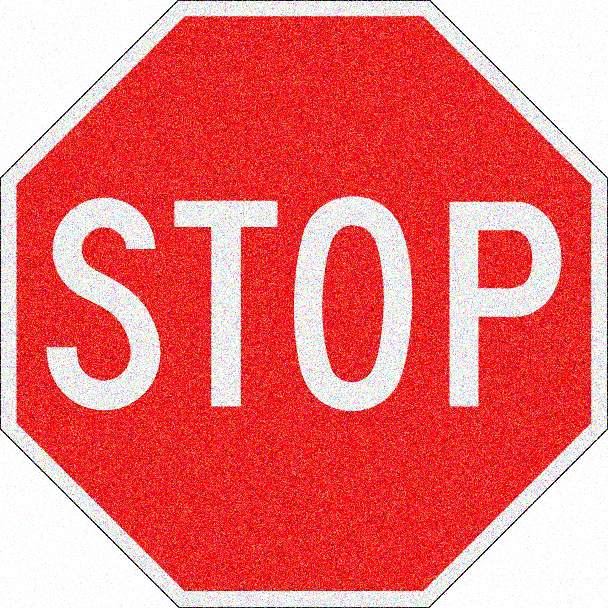

In [8]:
def noisy(img, std=50.0): # 10 - 70
    mean = 0.0   # some constant
    img = np.array(img, dtype=np.uint8)
    noisy_img = img + np.random.normal(mean, std, img.shape)
    noisy_img_clipped = np.clip(noisy_img, 0, 255)
    im = Image.fromarray(noisy_img_clipped.astype('uint8'))
    return im
noisy(img)

In [9]:
def perspective_changed(change):
    zz = rand_perspective(img, change.new)
    plt.imshow(zz)
w_perspective = widgets.FloatSlider(
    value=0.5,
    min=0,
    max=1.0,
    step=0.02,
    description='Perspective coeff:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)
w_perspective.observe(perspective_changed, names='value')

display(w_perspective)

FloatSlider(value=0.5, continuous_update=False, description='Perspective coeff:', max=1.0, step=0.02)

In [10]:
from PIL import ImageEnhance

brightness_enchancer = ImageEnhance.Brightness(img)

def brightness_changed(change):
    zz = brightness_enchancer.enhance(change.new)
    plt.imshow(zz)

w = widgets.FloatSlider(
    value=0.5,
    min=0,
    max=1.0,
    step=0.05,
    description='Brightness:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)
w.observe(brightness_changed, names='value')

display(w)

FloatSlider(value=0.5, continuous_update=False, description='Brightness:', max=1.0, step=0.05)

In [11]:
from PIL import ImageFilter

def blur_changed(change):
    blur_filter = ImageFilter.GaussianBlur(radius=change)
    zz = img.filter(blur_filter)
    plt.imshow(zz)

w = widgets.FloatSlider(
    value=1,
    min=1,
    max=200,
    step=1,
    description='Blur:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)
w.observe(brightness_changed, names='value')

display(w)

FloatSlider(value=1.0, continuous_update=False, description='Blur:', max=200.0, min=1.0, step=1.0)

In [12]:
images_to_augment = list(map(lambda x: np.array(x, dtype=np.uint8), images_to_augment))

In [13]:
def grid(images, rows, cols, border=1, border_color=255):
    nb_images = len(images)
    cell_height = max([image.shape[0] for image in images])
    cell_width = max([image.shape[1] for image in images])
    channels = set([image.shape[2] for image in images])
    assert len(channels) == 1
    nb_channels = list(channels)[0]
    if rows is None and cols is None:
        rows = cols = int(math.ceil(math.sqrt(nb_images)))
    elif rows is not None:
        cols = int(math.ceil(nb_images / rows))
    elif cols is not None:
        rows = int(math.ceil(nb_images / cols))
    assert rows * cols >= nb_images

    cell_height = cell_height + 1 * border
    cell_width = cell_width + 1 * border

    width = cell_width * cols
    height = cell_height * rows
    grid = np.zeros((height, width, nb_channels), dtype=np.uint8)
    cell_idx = 0
    for row_idx in range(rows):
        for col_idx in range(cols):
            if cell_idx < nb_images:
                image = images[cell_idx]
                border_top = border_right = border_bottom = border_left = border
                #if row_idx > 1:
                border_top = 0
                #if col_idx > 1:
                border_left = 0
                image = np.pad(image, ((border_top, border_bottom), (border_left, border_right), (0, 0)), mode="constant", constant_values=border_color)

                cell_y1 = cell_height * row_idx
                cell_y2 = cell_y1 + image.shape[0]
                cell_x1 = cell_width * col_idx
                cell_x2 = cell_x1 + image.shape[1]
                grid[cell_y1:cell_y2, cell_x1:cell_x2, :] = image
            cell_idx += 1

    grid = np.pad(grid, ((border, 0), (border, 0), (0, 0)), mode="constant", constant_values=border_color)

    return grid

In [14]:
def save_image(np_image, filename):
    image = Image.fromarray(np_image)
    image.save(filename + ".png")

In [15]:
from pycocotools.coco import COCO
coco_images_path = "/home/nfan/datasets/mscoco/train2017/*.jpg" 
coco_images_list = glob(coco_images_path)
len(coco_images_list)

118287

In [16]:
annFile = "/home/nfan/datasets/mscoco/train_label/annotations/instances_train2017.json"
coco = COCO(annFile)

loading annotations into memory...
Done (t=11.17s)
creating index...
index created!


In [17]:
catIds = coco.getCatIds(catNms=['stop sign'])
imgIds = coco.getImgIds(catIds = catIds)
print(len(imgIds))
stop_signs = []
for i in imgIds:
    stop_signs.append("/home/nfan/datasets/mscoco/train2017/" + str(i).zfill(12) + ".jpg")
for x in stop_signs:
    coco_images_list.remove(x)

1734


In [18]:
len(coco_images_list)

116553

In [19]:
def augment(obj_name, img):
    global idx
    images_aug = [img] * 3000
    
    for img in tqdm(images_aug):
        forground_img = Image.fromarray(img)
        background_img = Image.open(random.choice(coco_images_list))
        
        brightness_enchancer = ImageEnhance.Brightness(forground_img)
        forground_img = brightness_enchancer.enhance(random.uniform(0.4, 1.0))
        forground_img = forground_img.convert('RGBA')
        
        forground_img = rand_perspective(forground_img, 0.3)

        forground_img = noisy(forground_img, std=random.uniform(10, 70))
        forground_img = forground_img.filter(ImageFilter.GaussianBlur(radius=random.uniform(1, 10)))

        # forground_img = forground_img.rotate(int(random.gauss(0, 11)), expand=1)
        part = random.uniform(0.1, 0.5)

        forground_ratio = forground_img.size[0] / forground_img.size[1]
        if background_img.size[0] > background_img.size[1]:
            width = background_img.size[0] * part
            height = width / forground_ratio

            if height > background_img.size[1]:
                height = background_img.size[1]
                width = height * forground_ratio
        else:
            height = background_img.size[1] * part
            width = height * forground_ratio

            if width > background_img.size[0]:
                width = background_img.size[0]
                height = width / forground_ratio

        width = int(width)
        height = int(height)
        x = random.randint(0, background_img.size[0] - width)
        y = random.randint(0, background_img.size[1] - height)

        f_img = forground_img.resize((width, height))
        background_img.paste(f_img, (x, y), f_img)
        
        name = "img_{:07}".format(idx)
        idx += 1

        background_img.save("./images/{}.jpg".format(name))

        annotation = {}
        annotation["filename"] = "{}.jpg".format(name)
        size = {"width": background_img.size[0],
               "height": background_img.size[1],
               "depth": 3}
        annotation["size"] = size
        annotation["segmented"] = 0
        obj = {
            "name": obj_name,
            "pose": "Unspecified",
            "truncated": 0,
            "difficult": 0,
            "bndbox": {
                "xmin": x,
                "ymin": y,
                "xmax": x + width,
                "ymax": y + height
            }
        }
        annotation["object"] = obj
        xml = dicttoxml(annotation, custom_root='annotation', attr_type=False)
        with open("./annotations/{}.xml".format(name), "wb") as f:
            f.write(xml)

idx = 0
for obj_name, img in zip(object_names, images_to_augment):
    augment(obj_name, img)

100%|██████████| 3000/3000 [09:28<00:00,  5.23it/s]


In [20]:
# gr = grid(images_aug, cols=8, rows=4)
# plt.imshow(gr)
# save_image(gr, "grid")

# https://stackoverflow.com/a/14178717
def find_coeffs(pa, pb):
    matrix = []
    for p1, p2 in zip(pa, pb):
        matrix.append([p1[0], p1[1], 1, 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1]])
        matrix.append([0, 0, 0, p1[0], p1[1], 1, -p2[1]*p1[0], -p2[1]*p1[1]])

    A = np.matrix(matrix, dtype=numpy.float)
    B = np.array(pb).reshape(8)

    res = np.dot(np.linalg.inv(A.T * A) * A.T, B)
    return np.array(res).reshape(8)